In [27]:
import json
import copy
import os
from os import path
from tqdm import tqdm
from tld import get_fld
import matplotlib.pyplot as plt
from IPython.display import display_markdown, Image

import pandas as pd
pd.options.plotting.backend = "matplotlib"

import plotly.io as pio
import plotly.express as px
blue = px.colors.qualitative.Plotly[0]
red = px.colors.qualitative.Plotly[1]
green = px.colors.qualitative.Plotly[2]

def printMD(txt):
    display_markdown(txt, raw=True)

In [28]:
# Modified plotly template based on the standard plotly_white template
my_template = copy.deepcopy(pio.templates["plotly_white"])
my_template.layout.margin = dict(l=0, b=0, r=0, t=0, pad=0)
my_template.layout.font.color = "black"
my_template.layout.annotationdefaults = dict(font=dict(color="black"))
my_template.layout.shapedefaults.line.color = "black"
my_template.layout.legend.xanchor = "right"
my_template.layout.legend.yanchor = "top"
pio.templates.default = my_template

## Load crawl data from JSON files

In [3]:
def loadDataFromFolder(folder_name: str):
    DATA_PATH_PREFIX = "/mnt/data/MT/"
    folder_path = path.join(DATA_PATH_PREFIX, folder_name)
    
    def isCrawlDataFile(filename: str):
        return filename.endswith(".json") and filename != "metadata.json" and path.isfile(path.join(folder_path, filename))
    
    json_files = [f for f in os.listdir(folder_path) if isCrawlDataFile(f)]
    print("Found %d JSON files" % len(json_files))

    all_sites = []
    all_calls = []
    for filename in tqdm(json_files):
        with open(path.join(folder_path, filename)) as file:
            crawl_data = json.load(file)
            initial_url = crawl_data["initialUrl"]
            final_url = crawl_data["finalUrl"]
            all_sites.append({
                "initialUrl": initial_url,
                "finalUrl": final_url,
                "timeout": crawl_data["timeout"]
            })

            # Sort saved calls
            ps_data = crawl_data["data"]["privacySandbox"]
            if not ps_data:
                continue

            subpages = ps_data["crawledSubpages"]

            saved_calls = ps_data["savedCalls"]
            if len(saved_calls) == 0:
                continue

            for saved_call in saved_calls:
                si = saved_call["subpageIndex"]
                saved_call["initialUrl"] = subpages[si]["initialUrl"] if si >= 0 else initial_url
                saved_call["finalUrl"] = subpages[si]["finalUrl"] if si >= 0 else final_url
                all_calls.append(saved_call)

    pd.DataFrame(all_sites).to_csv(f"{folder_name}-sites.csv", index=False)
    del all_sites

    pd.DataFrame(all_calls).to_csv(f"{folder_name}-calls.csv", index=False)
    del all_calls

In [5]:
loadDataFromFolder("pilot-crawl4")

Found 671 JSON files


  0%|          | 0/671 [00:00<?, ?it/s]

100%|██████████| 671/671 [00:11<00:00, 58.30it/s]


## Analyzing the crawl data

In [10]:
sites_df = pd.read_csv("pilot-crawl4-sites.csv")
calls_df = pd.read_csv("pilot-crawl4-calls.csv")

nr_of_crawled_sites = len(sites_df.groupby("finalUrl"))
print(f"{nr_of_crawled_sites} crawled sites ({len(sites_df) - nr_of_crawled_sites} finalUrl duplicates)")
print(f"{len(sites_df[sites_df['timeout']])}/{len(sites_df)} timeouts")

calls_df["initialUrlFld"] = calls_df["initialUrl"].apply(get_fld)
calls_df["finalUrlFld"] = calls_df["finalUrl"].apply(get_fld)
calls_df["sourceFld"] = calls_df["source"].apply(get_fld)

display(calls_df.head())

609 crawled sites (62 finalUrl duplicates)
61/671 timeouts


,source,description,arguments,returnValue,accessType,frameURL,referrer,subpageIndex,initialUrl,finalUrl,initialUrlFld,finalUrlFld,sourceFld
0,https://snap.licdn.com/li.lms-analytics/insigh...,Document.browsingTopics,{},{},call,https://www.33across.com/,NaN,-1,http://33across.com/,https://www.33across.com/,33across.com,33across.com,licdn.com
1,https://snap.licdn.com/li.lms-analytics/insigh...,Document.browsingTopics,{},{},call,https://www.33across.com/lexicon-for-dsps/,NaN,-1,http://33across.com/,https://www.33across.com/,33across.com,33across.com,licdn.com
2,https://snap.licdn.com/li.lms-analytics/insigh...,Document.browsingTopics,{},{},call,https://www.33across.com/news/,NaN,0,https://www.33across.com/lexicon-for-dsps/,https://www.33across.com/lexicon-for-dsps/,33across.com,33across.com,licdn.com
3,https://snap.licdn.com/li.lms-analytics/insigh...,Document.browsingTopics,{},{},call,https://triplelift.com/,https://cdn.3lift.com/,-1,http://3lift.com/,https://triplelift.com/,3lift.com,triplelift.com,licdn.com
4,https://snap.licdn.com/li.lms-analytics/insigh...,Document.browsingTopics,{},{},call,https://triplelift.com/products/advertising-me...,NaN,0,https://triplelift.com/products/advertising-me...,https://triplelift.com/products/advertising-me...,triplelift.com,triplelift.com,licdn.com


### On which sites are the APIs being called?

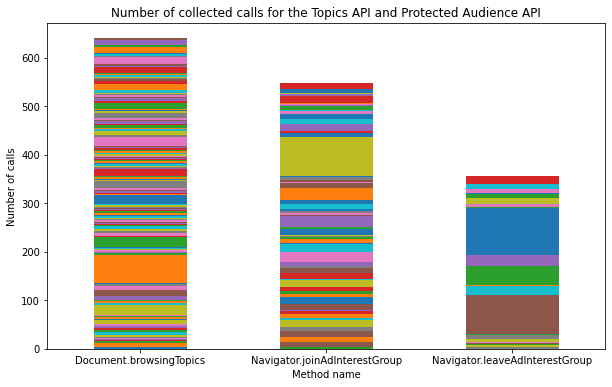

In [11]:
ax = calls_df.groupby("description")["finalUrlFld"].value_counts().unstack().plot.bar(
    stacked = True,
    legend = False,
    title = "Number of collected calls for the Topics API and Protected Audience API",
    xlabel = "Method name",
    ylabel = "Number of calls",
    figsize = (10,6),
    rot = 0
)

In [11]:
for call_type, call_data in calls_df.groupby("description"):
    per_site = call_data.groupby("finalUrlFld")
    printMD(f"{len(call_data)} calls for `{call_type}`, on {len(per_site)} distinct sites ({len(per_site) / nr_of_crawled_sites:.1%} of all successfully crawled sites):")
    display(per_site["sourceFld"].describe().sort_values(by="count", ascending=False))

640 calls for `Document.browsingTopics`, on 135 distinct sites (22.2% of all successfully crawled sites):

,count,unique,top,freq
finalUrlFld,,,,
elmundo.es,58,5,doubleclick.net,49
freepik.com,21,4,rubiconproject.com,13
repubblica.it,20,4,doubleclick.net,9
chess.com,20,3,rubiconproject.com,14
mailchimp.com,18,1,teads.tv,18
...,...,...,...,...
liftoff.io,1,1,licdn.com,1
forter.com,1,1,licdn.com,1
free.fr,1,1,creativecdn.com,1


548 calls for `Navigator.joinAdInterestGroup`, on 63 distinct sites (10.3% of all successfully crawled sites):

,count,unique,top,freq
finalUrlFld,,,,
samsung.com,81,1,doubleclick.net,81
newrelic.com,25,1,doubleclick.net,25
lenovo.com,23,1,doubleclick.net,23
grammarly.com,20,1,doubleclick.net,20
hilton.com,17,1,doubleclick.net,17
...,...,...,...,...
wayfair.com,1,1,doubleclick.net,1
paloaltonetworks.com,1,1,doubleclick.net,1
uber.com,1,1,doubleclick.net,1


356 calls for `Navigator.leaveAdInterestGroup`, on 27 distinct sites (4.4% of all successfully crawled sites):

,count,unique,top,freq
finalUrlFld,,,,
mailchimp.com,96,1,doubleclick.net,96
google.com,81,1,doubleclick.net,81
klaviyo.com,39,1,doubleclick.net,39
lenovo.com,24,1,doubleclick.net,24
hilton.com,18,1,doubleclick.net,18
wordpress.com,16,1,doubleclick.net,16
samsung.com,11,1,doubleclick.net,11
trendmicro.com,9,1,doubleclick.net,9
expedia.com,8,1,doubleclick.net,8


- `count`: total number of calls per site
- `unique`: number of unique callers per site
- `top`: caller with the most calls per site
- `freq`: number of calls for the `top` caller

Pilot crawl 2:
- 629 calls for `Document.browsingTopics`, on 98 distinct sites (13.41% of all successfully crawled sites)
- 141 calls for `Navigator.joinAdInterestGroup`, on 24 distinct sites (3.28% of all successfully crawled sites)
- 34 calls for `Navigator.runAdAuction`, on 4 distinct sites (0.55% of all successfully crawled sites)

Pilot crawl 3:
- 514 calls for `Document.browsingTopics`, on 108 distinct sites (17.5% of all successfully crawled sites)
- 468 calls for `Navigator.joinAdInterestGroup`, on 63 distinct sites (10.2% of all successfully crawled sites)
- 7 calls for `Navigator.runAdAuction`, on 2 distinct sites (0.3% of all successfully crawled sites)

Since the 4th pilot crawl we now also collect `Navigator.leaveAdInterestGroup` and `Navigator.updateAdInterestGroups`

^ *Note: the 4th crawl did not capture any calls to `Navigator.runAdAuction`*

### From which sources are the API calls coming?

In [27]:
for call_type, call_data in calls_df.groupby("description"):
    per_source = call_data.groupby("sourceFld")
    printMD(f"{len(call_data.groupby('finalUrlFld'))} websites with calls for `{call_type}`, from {len(per_source)} distinct callers:")
    display(per_source["finalUrlFld"].describe().sort_values(by="unique", ascending=False))

135 websites with calls for `Document.browsingTopics`, from 11 distinct callers:

,count,unique,top,freq
sourceFld,,,,
licdn.com,274,99,atlassian.com,8
criteo.com,40,19,nicovideo.jp,5
doubleclick.net,115,17,elmundo.es,49
rubiconproject.com,84,12,chess.com,14
taboola.com,29,12,elmundo.es,4
teads.tv,72,7,mailchimp.com,18
creativecdn.com,9,6,soundcloud.com,4
top100.ru,9,3,livejournal.com,3
affec.tv,3,1,name.com,3


63 websites with calls for `Navigator.joinAdInterestGroup`, from 1 distinct callers:

,count,unique,top,freq
sourceFld,,,,
doubleclick.net,548,63,samsung.com,81


27 websites with calls for `Navigator.leaveAdInterestGroup`, from 2 distinct callers:

,count,unique,top,freq
sourceFld,,,,
doubleclick.net,353,24,mailchimp.com,96
retargetly.com,3,3,epsilon.com,1


^ *Note: why does Retargetly call `leaveAdInterestGroup` but not `joinAdInterestGroup`?*

- `count`: total number of calls per caller
- `unique`: number of unique websites the caller appears on
- `top`: website with the most calls from the caller
- `freq`: number of calls for the `top` website

### Analyzing `joinAdInterestGroup` calls

In [28]:
seconds_to_days = 1 / (60 * 60 * 24)
join_calls = calls_df[calls_df["description"] == "Navigator.joinAdInterestGroup"].copy()
join_calls["duration"] = join_calls["arguments"].apply(lambda arg: arg["1"] * seconds_to_days)

for subArg in ["owner", "name"]:
    join_calls[subArg] = join_calls["arguments"].apply(lambda arg: arg["0"].get(subArg))

for subArg in ["ads", "adComponents"]:
    join_calls[subArg] = join_calls["arguments"].apply(lambda arg: arg["0"].get(subArg, []))
    join_calls[f"{subArg}Len"] = join_calls[subArg].apply(lambda ads: len(ads))

display(join_calls.head(3))

,source,description,arguments,returnValue,accessType,frameURL,referrer,subpageIndex,initialUrl,finalUrl,initialUrlFld,finalUrlFld,sourceFld,duration,owner,name,ads,adsLen,adComponents,adComponentsLen
16,https://td.doubleclick.net/td/rul/993517329?ra...,Navigator.joinAdInterestGroup,"{'0': {'owner': 'https://td.doubleclick.net', ...",{},call,https://td.doubleclick.net/td/rul/993517329?ra...,https://www.digitalturbine.com/,-1,http://adcolony.com/,https://www.digitalturbine.com/,adcolony.com,digitalturbine.com,doubleclick.net,30.0,https://td.doubleclick.net,1j391717425,[{'renderUrl': 'https://tdsf.doubleclick.net/t...,12,[],0
17,https://td.doubleclick.net/td/rul/993517329?ra...,Navigator.joinAdInterestGroup,"{'0': {'owner': 'https://td.doubleclick.net', ...",{},call,https://td.doubleclick.net/td/rul/993517329?ra...,https://www.digitalturbine.com/,-1,http://adcolony.com/,https://www.digitalturbine.com/,adcolony.com,digitalturbine.com,doubleclick.net,30.0,https://td.doubleclick.net,1j215464351,[{'renderUrl': 'https://tdsf.doubleclick.net/t...,12,[],0
19,https://td.doubleclick.net/td/rul/993517329?ra...,Navigator.joinAdInterestGroup,"{'0': {'owner': 'https://td.doubleclick.net', ...",{},call,https://td.doubleclick.net/td/rul/993517329?ra...,https://www.digitalturbine.com/,-1,http://adcolony.com/,https://www.digitalturbine.com/,adcolony.com,digitalturbine.com,doubleclick.net,30.0,https://td.doubleclick.net,1j215464351,[{'renderUrl': 'https://tdsf.doubleclick.net/t...,12,[],0


#### Interest group owners

In [29]:
join_calls.groupby("owner")["finalUrlFld"].describe().sort_values(by="unique", ascending=False)

,count,unique,top,freq
owner,,,,
https://td.doubleclick.net,548,63,samsung.com,81


^ *Note: no more calls from Criteo in the 4th pilot crawl*

- `count`: total number of calls per owner
- `unique`: number of unique websites the owner appears on
- `top`: website with the most calls from the owner
- `freq`: number of calls for the `top` website

#### Durations/lifetime of interest groups
According to the [documentation](https://developer.chrome.com/docs/privacy-sandbox/protected-audience-api/interest-groups/#example-usage), the duration of interest groups is capped at 30 days (2592000 seconds).

,count,mean,std,min,25%,50%,75%,max
owner,,,,,,,,
https://td.doubleclick.net,548.0,122.483577,168.606271,1.0,30.0,30.0,120.0,540.0


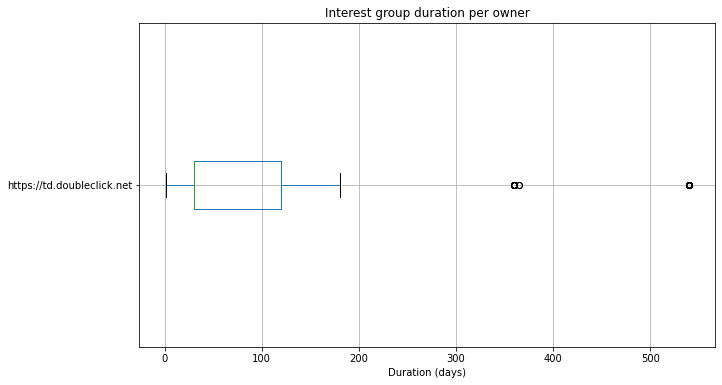

In [30]:
ax = join_calls.boxplot(
    column = "duration",
    by = "owner",
    vert = False,
    figsize = (10,6)
)
ax.get_figure().suptitle("")
ax.set_title("Interest group duration per owner")
ax.set_xlabel("Duration (days)")

join_calls.groupby("owner")["duration"].describe()

#### Number of ads per interest group

,count,mean,std,min,25%,50%,75%,max
owner,,,,,,,,
https://td.doubleclick.net,548.0,32.169708,45.313598,1.0,5.0,15.0,37.0,240.0


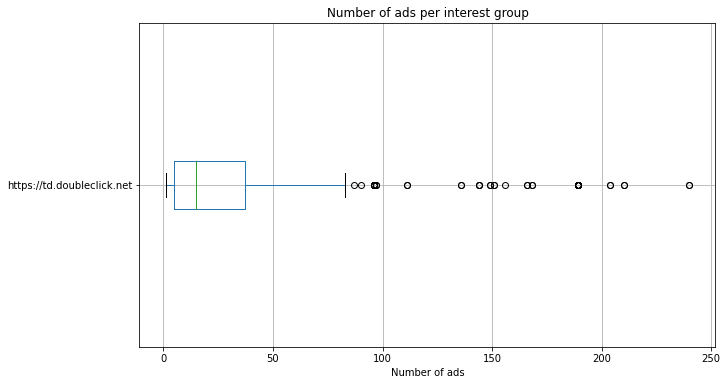

In [31]:
ax = join_calls.boxplot(
    column = "adsLen",
    by = "owner",
    vert = False,
    figsize = (10,6)
)
ax.get_figure().suptitle("")
ax.set_title("Number of ads per interest group")
ax.set_xlabel("Number of ads")

join_calls.groupby("owner")["adsLen"].describe()

#### Sites with the largest number of ads in a single interest group

In [32]:
for source, data in join_calls[["sourceFld", "finalUrlFld", "adsLen"]].groupby("sourceFld"):
    printMD("Interest groups with most ads for %s:" % source)
    display(data.groupby("finalUrlFld").max(numeric_only=True).sort_values("adsLen", ascending=False).head(5))

Interest groups with most ads for doubleclick.net:

,adsLen
finalUrlFld,
upwork.com,240
grammarly.com,210
conviva.com,204
newrelic.com,189
hilton.com,168


#### Some example `renderUrl`'s from the ads

In [54]:
txt = ""
for ad in join_calls[(join_calls["sourceFld"] == "criteo.com") & (join_calls["finalUrlFld"] == "nike.com")].iloc[0].ads:
    txt += f"- `{ad.get('renderURL')}`\n"
printMD(txt)

- `https://fledge.us.criteo.com/delivery/fledge?campaignId=398589&bannerId=11406645&width=${AD_WIDTH}&height=${AD_HEIGHT}`
- `https://fledge.us.criteo.com/delivery/fledge?campaignId=390628&bannerId=11382699&width=${AD_WIDTH}&height=${AD_HEIGHT}`
- `https://fledge.us.criteo.com/delivery/fledge?campaignId=398591&bannerId=11406651&width=${AD_WIDTH}&height=${AD_HEIGHT}`
- `https://fledge.us.criteo.com/delivery/fledge?campaignId=168485&bannerId=11099608&width=${AD_WIDTH}&height=${AD_HEIGHT}`
- `https://fledge.us.criteo.com/delivery/fledge?campaignId=398590&bannerId=11406648&width=${AD_WIDTH}&height=${AD_HEIGHT}`
- `https://fledge.us.criteo.com/delivery/fledge?campaignId=277254&bannerId=11016018&width=${AD_WIDTH}&height=${AD_HEIGHT}`
- `https://fledge.us.criteo.com/delivery/fledge?campaignId=168209&bannerId=11099606&width=${AD_WIDTH}&height=${AD_HEIGHT}`


^ *Note: this is still from the 3rd pilot crawl, the 4th pilot crawl had not calls from Criteo*

In [33]:
txt = ""
for ad in join_calls[(join_calls["sourceFld"] == "doubleclick.net") & (join_calls["finalUrlFld"] == "upwork.com")].iloc[0].ads:
    txt += f"- `{ad.get('renderUrl')}`\n"
    if len(txt) > 1600:
        txt += "- ..."
        break
printMD(txt)

- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=152324381249&cr_id=660478723091&cv_id=2&format=${AD_WIDTH}x${AD_HEIGHT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=152324381249&cr_id=660478723094&cv_id=2&format=${AD_WIDTH}x${AD_HEIGHT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=152324381249&cr_id=660478723097&cv_id=2&format=${AD_WIDTH}x${AD_HEIGHT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=152324381249&cr_id=660478723100&cv_id=2&format=${AD_WIDTH}x${AD_HEIGHT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=152324381249&cr_id=660478723103&cv_id=2&format=${AD_WIDTH}x${AD_HEIGHT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=152324381249&cr_id=660537414646&cv_id=2&format=${AD_WIDTH}x${AD_HEIGHT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=152324381249&cr_id=660537414649&cv_id=2&format=${AD_WIDTH}x${AD_HEIGHT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=152324381249&cr_id=660537414652&cv_id=2&format=${AD_WIDTH}x${AD_HEIGHT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=152324381249&cr_id=660537414655&cv_id=2&format=${AD_WIDTH}x${AD_HEIGHT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=152324381249&cr_id=660537414658&cv_id=2&format=${AD_WIDTH}x${AD_HEIGHT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=152324381249&cr_id=660599007020&cv_id=2&format=${AD_WIDTH}x${AD_HEIGHT}&rds=${RENDER_DATA}`
- ...

#### Number of ad components per interest group

,count,mean,std,min,25%,50%,75%,max
owner,,,,,,,,
https://td.doubleclick.net,548.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


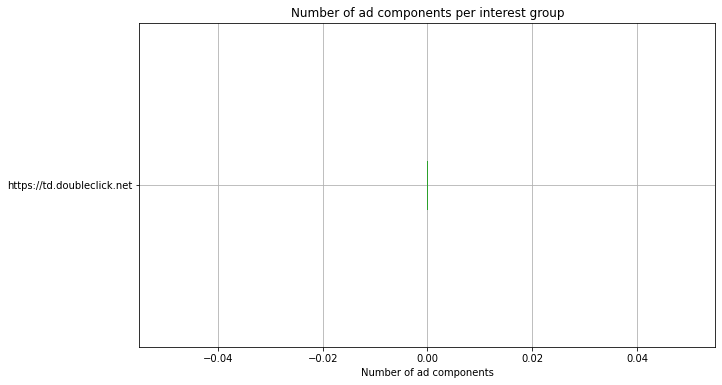

In [34]:
ax = join_calls.boxplot(
    column = "adComponentsLen",
    by = "owner",
    vert = False,
    figsize = (10,6)
)
ax.get_figure().suptitle("")
ax.set_title("Number of ad components per interest group")
ax.set_xlabel("Number of ad components")

join_calls.groupby("owner")["adComponentsLen"].describe()

^ *Note: no interest groups seem to use ad components so far*

### Analyzing `runAdAuction` calls

In [13]:
auction_calls = calls_df[calls_df["description"] == "Navigator.runAdAuction"].copy()
auction_calls["seller"] = auction_calls["arguments"].apply(lambda arg: arg["0"].get("seller"))

display(auction_calls.head(3))

,source,description,arguments,returnValue,accessType,frameURL,referrer,subpageIndex,initialUrl,finalUrl,initialUrlFld,finalUrlFld,sourceFld,seller
875,https://securepubads.g.doubleclick.net/pagead/...,Navigator.runAdAuction,{'0': {'seller': 'https://securepubads.g.doubl...,{},call,https://ameblo.jp/chunta-2011/,,1,http://ameblo.jp/,https://ameblo.jp/,ameblo.jp,ameblo.jp,doubleclick.net,https://securepubads.g.doubleclick.net
979,https://securepubads.g.doubleclick.net/pagead/...,Navigator.runAdAuction,{'0': {'seller': 'https://securepubads.g.doubl...,{},call,https://www.yahoo.com/,,-1,http://yahoo.net/,https://www.yahoo.com/,yahoo.net,yahoo.com,doubleclick.net,https://securepubads.g.doubleclick.net
980,https://securepubads.g.doubleclick.net/pagead/...,Navigator.runAdAuction,{'0': {'seller': 'https://securepubads.g.doubl...,{},call,https://www.yahoo.com/,,-1,http://yahoo.net/,https://www.yahoo.com/,yahoo.net,yahoo.com,doubleclick.net,https://securepubads.g.doubleclick.net


^ *Note: there were no calls of `runAdAuction` captured in the 4th pilot crawl, so these results are from the 3rd pilot crawl*

#### Who are the auction sellers?

In [14]:
auction_calls.groupby("seller")["finalUrlFld"].describe().sort_values(by="unique", ascending=False)

,count,unique,top,freq
seller,,,,
https://securepubads.g.doubleclick.net,7,2,yahoo.com,6


- `count`: total number of calls per seller
- `unique`: number of unique websites the seller appears on
- `top`: website with the most calls from the seller
- `freq`: number of calls for the `top` website

### Did the calls come from crawled subpages?

In [12]:
subpage_calls = calls_df.groupby("description")["subpageIndex"].value_counts().unstack().fillna(0)
display(subpage_calls)

subpageIndex,-1,0,1
description,,,
Document.browsingTopics,325,204,111
Navigator.joinAdInterestGroup,208,196,144
Navigator.leaveAdInterestGroup,112,143,101


In [34]:
subpage_calls.reset_index().melt(id_vars="description", value_vars=[-1, 0, 1])

,description,subpageIndex,value
0,Document.browsingTopics,-1,325
1,Navigator.joinAdInterestGroup,-1,208
2,Navigator.leaveAdInterestGroup,-1,112
3,Document.browsingTopics,0,204
4,Navigator.joinAdInterestGroup,0,196
5,Navigator.leaveAdInterestGroup,0,143
6,Document.browsingTopics,1,111
7,Navigator.joinAdInterestGroup,1,144
8,Navigator.leaveAdInterestGroup,1,101


In [37]:
pd.options.plotting.backend = "plotly"

Number of collected calls per subpage

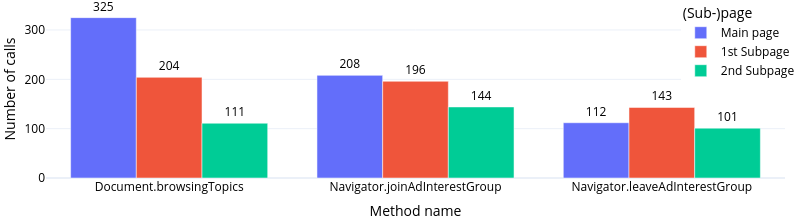

In [67]:
df = subpage_calls.reset_index().melt(id_vars="description", value_vars=[-1, 0, 1])
fig = df.plot.bar(
    # title = "Number of collected calls per subpage",
    x = "description",
    y = "value",
    color = "subpageIndex",
    barmode = "group",
    labels = {
        "description": "Method name",
        "value": "Number of calls",
        "subpageIndex": "(Sub-)page",
        "-1": "Main Page",
        
    },
    text_auto = True
)
fig.update_traces(textfont_color="black", textposition = "outside")
fig.update_layout(margin=dict(t=0), yaxis=dict(range=[0, df["value"].max() * 1.11]))

new = {"-1": "Main page", "0": "1st Subpage", "1": "2nd Subpage"}
fig.for_each_trace(lambda t: t.update(name = new[t.name]))

printMD("Number of collected calls per subpage")
fig.write_image("../../mt-latex/figures/subpages-total-calls.pdf", width=800, height=220)
display(Image(fig.to_image(format="png", width=800, height=220)))

In [40]:
first_subpage_calls = calls_df.groupby(["description", "finalUrlFld"])["subpageIndex"].min().reset_index(level="finalUrlFld")["subpageIndex"] \
    .groupby("description").value_counts().unstack().fillna(0)
display(first_subpage_calls)

subpageIndex,-1,0,1
description,,,
Document.browsingTopics,125.0,9.0,1.0
Navigator.joinAdInterestGroup,50.0,13.0,0.0
Navigator.leaveAdInterestGroup,17.0,8.0,2.0


First occurrence of a method call per site

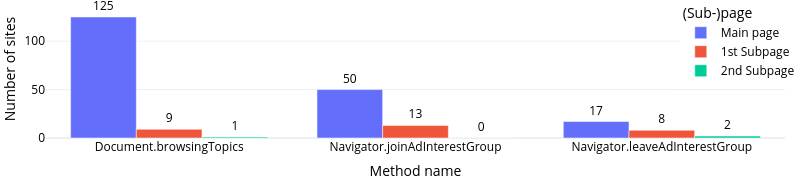

In [69]:
df = first_subpage_calls.reset_index().melt(id_vars="description", value_vars=[-1, 0, 1])
fig = df.plot.bar(
    # title = "First occurrence of a method call per site",
    x = "description",
    y = "value",
    color = "subpageIndex",
    barmode = "group",
    labels = {
        "description": "Method name",
        "value": "Number of sites",
        "subpageIndex": "(Sub-)page",
        
    },
    text_auto = True
)
fig.update_traces(textfont_color="black", textposition = "outside")
fig.update_layout(margin=dict(t=0), yaxis=dict(range=[0, df["value"].max() * 1.14]))

new = {"-1": "Main page", "0": "1st Subpage", "1": "2nd Subpage"}
fig.for_each_trace(lambda t: t.update(name = new[t.name]))

printMD("First occurrence of a method call per site")
fig.write_image("../../mt-latex/figures/subpages-first-occurrence.pdf", width=800, height=180)
display(Image(fig.to_image(format="png", width=800, height=180)))

^ *Based on these results, it probably makes sense to only crawl 1 subpage per site in the final crawl to speed things up (although the 2nd subpage did have slightly more results in the 3rd pilot crawl)*

In [22]:
firstSubpage = calls_df.groupby(["description", "finalUrlFld"])["subpageIndex"].min()
display(firstSubpage[firstSubpage == 1])

description                     finalUrlFld   
Document.browsingTopics         agoda.com         1
Navigator.leaveAdInterestGroup  calendly.com      1
                                trendmicro.com    1
Name: subpageIndex, dtype: int64